**Global Configuration**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings (optional but helpful)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

DATA_DIR = r"D:\MATH-499\data\company-wise"
CUTOFF_DATE = pd.Timestamp("2024-01-01")
MIN_OBS = 200


**SCAN folder & Create Stock List**

In [3]:
stocks = tuple(
    f.replace(".csv", "")
    for f in os.listdir(DATA_DIR)
    if f.endswith(".csv")
)

print(f"Total stocks found: {len(stocks)}")
stocks[:10]


Total stocks found: 124


('ADBL',
 'AHPC',
 'AKJCL',
 'AKPL',
 'ALICL',
 'API',
 'BARUN',
 'BFC',
 'BOKL',
 'BPCL')

**Load & Clean Data**

In [4]:
def load_stock_data(stock):
    file_path = os.path.join(DATA_DIR, f"{stock}.csv")
    
    df = pd.read_csv(file_path)
    
    df.rename(columns={
        "published_date": "Date",
        "open": "Open",
        "high": "High",
        "low": "Low",
        "close": "Close",
        "per_change": "Pct_Change",
        "traded_quantity": "Volume",
        "traded_amount": "Turnover",
        "status": "Status"
    }, inplace=True)
    
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Keep only active trading days
    df = df[df["Status"] == 0]
    
    # Sort chronologically
    df.sort_values("Date", inplace=True)
    df.set_index("Date", inplace=True)
    
    return df


In [5]:
import matplotlib.pyplot as plt

def plot_sma(stock):
    df = load_stock_data(stock)
    df = compute_sma(df)
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Close"], label="Close Price", linewidth=1.4)
    plt.plot(df.index, df["SMA_50"], label="50-Day SMA", linestyle="--")
    plt.plot(df.index, df["SMA_200"], label="200-Day SMA", linestyle="--")
    
    plt.title(f"{stock} | NEPSE Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (NPR)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


**Filter Stocks** \
CriteriaL: Pre-2024, Active and with History

In [6]:
def is_stock_eligible(stock):
    try:
        df = load_stock_data(stock)
        traded_before_2024 = (df.index < CUTOFF_DATE).any()
        sufficient_history = len(df) >= MIN_OBS
        return traded_before_2024 and sufficient_history
    except:
        return False


In [7]:
filtered_stocks = tuple(s for s in stocks if is_stock_eligible(s))
dropped_stocks = tuple(set(stocks) - set(filtered_stocks))

print(f"Eligible stocks: {len(filtered_stocks)}")
print(f"Dropped stocks: {len(dropped_stocks)}")


Eligible stocks: 82
Dropped stocks: 42


**Log Return**

In [8]:
def add_log_returns(df):
    df = df.copy()
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    return df.dropna()


**Return Matrix**   
Formula: Stock x Tim

In [9]:
def build_return_matrix(stocks):
    returns = pd.DataFrame()
    
    for stock in stocks:
        try:
            df = load_stock_data(stock)
            df = add_log_returns(df)
            returns[stock] = df["log_return"]
        except:
            continue
    
    return returns   # ❗ DO NOT drop columns


In [10]:
returns_df = build_return_matrix(filtered_stocks)

print("Return matrix shape:", returns_df.shape)
returns_df.tail()


c:\Users\abhin\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\abhin\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Return matrix shape: (1801, 15)


,ADBL,AKPL,BFC,BOKL,CHL,DHPL,GRDBL,HIDCL,KKHC,KSBBL,LBBL,NGPL,SFCL,SPDL,UMHL
Date,,,,,,,,,,,,,,,
2024-12-17,-0.105981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-17,-0.104671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-09-23,0.089021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-15,-0.028802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-12,0.016103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Correlation Matrix**

In [11]:
corr_matrix = returns_df.corr(method="pearson", min_periods=30)

print(corr_matrix.shape)
corr_matrix.iloc[:5, :5]


(15, 15)


,ADBL,AKPL,BFC,BOKL,CHL
ADBL,1.000000,0.163202,0.024652,0.325615,0.124258
AKPL,0.163202,1.000000,0.176022,0.093609,0.263859
BFC,0.024652,0.176022,1.000000,0.207523,0.325620
BOKL,0.325615,0.093609,0.207523,1.000000,0.185225
CHL,0.124258,0.263859,0.325620,0.185225,1.000000


In [12]:
# Make a copy
corr_clean = corr_matrix.copy()

# 1️⃣ Remove self-correlation by setting diagonal to NaN
np.fill_diagonal(corr_clean.values, np.nan)

# 2️⃣ Remove redundant correlations (keep upper triangle only)
upper_tri = corr_clean.where(np.triu(np.ones(corr_clean.shape), k=1).astype(bool))

# 3️⃣ Optional: melt to long format for easy inspection
corr_long = upper_tri.stack().reset_index()
corr_long.columns = ["Stock_A", "Stock_B", "Correlation"]

# 4️⃣ Sort by absolute correlation descending
corr_long["Abs_Corr"] = corr_long["Correlation"].abs()
corr_long = corr_long.sort_values("Abs_Corr", ascending=False).reset_index(drop=True)

# Show top 10 most correlated stock pairs
corr_long.head(10)


,Stock_A,Stock_B,Correlation,Abs_Corr
0,AKPL,UMHL,0.468031,0.468031
1,HIDCL,UMHL,0.442444,0.442444
2,AKPL,KSBBL,0.439290,0.439290
3,BOKL,HIDCL,0.427926,0.427926
4,DHPL,KKHC,0.419607,0.419607
5,CHL,KKHC,0.409878,0.409878
6,BOKL,LBBL,0.377090,0.377090
7,BOKL,KSBBL,0.339298,0.339298
8,BFC,CHL,0.325620,0.325620
9,ADBL,BOKL,0.325615,0.325615


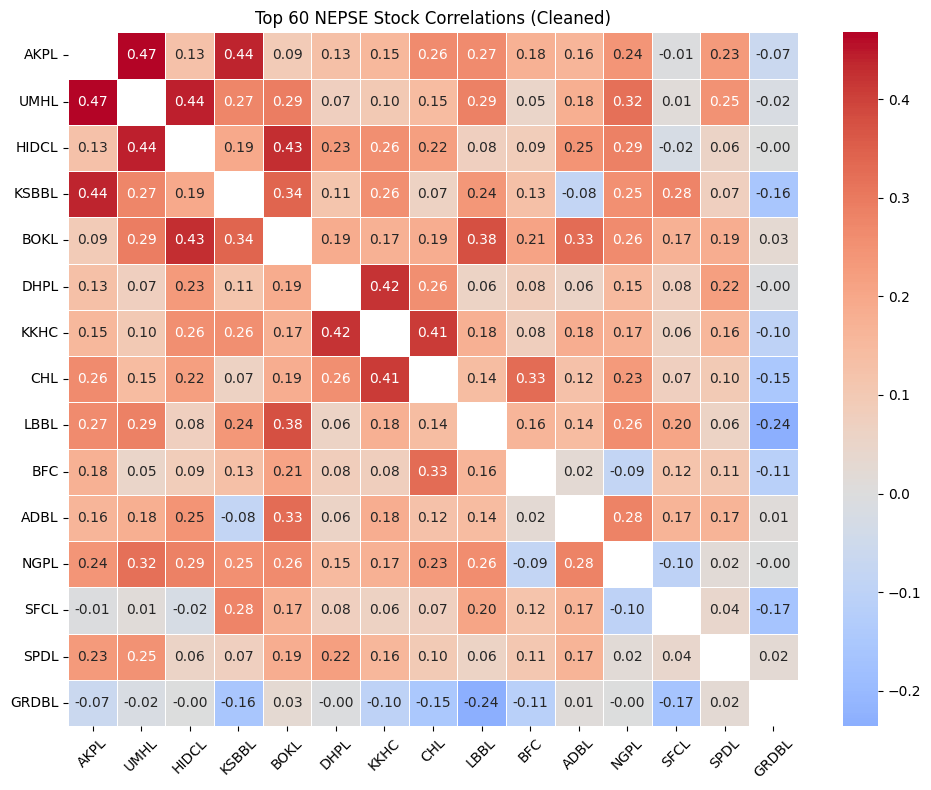

In [13]:
TOP_N = 60  # top 20 strongest correlations

# Select top N pairs
top_corr_pairs = corr_long.head(TOP_N)

# Get unique stocks involved
stocks_to_plot = pd.unique(top_corr_pairs[["Stock_A", "Stock_B"]].values.ravel())

# Subset correlation matrix
subset_corr = corr_matrix.loc[stocks_to_plot, stocks_to_plot]

# Mask self-correlation
mask = np.eye(len(subset_corr), dtype=bool)

plt.figure(figsize=(10, 8))
sns.heatmap(
    subset_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    mask=mask,
    linewidths=0.5
)
plt.title(f"Top {TOP_N} NEPSE Stock Correlations (Cleaned)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
